# 05.05 - Modeling Setup - Forecast Diagnostics

## Imports & setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('grayscale')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler

sys.path.append("..")
from src.models.models import SetTempAsPower, SK_Prophet
from src.utils.utils import bound_precision, AnnualTimeSeriesSplit

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load Test Data

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-cut.csv', parse_dates=True, index_col=0)
df = df.loc['1994': '1998']
df = df.resample('D').max()
# Just select a reasonable subset of data to test the model wrappers
df = df[['temp', 'dew_point_temp', 'week_of_year', 'daily_peak']]
df.rename(columns={'temp': 'temp_max'}, inplace=True)

y = df.pop('daily_peak')
X = df

X.head()

,temp_max,dew_point_temp,week_of_year
1994-01-01,2.8,1.1,52.0
1994-01-02,1.7,0.5,52.0
1994-01-03,-10.3,-12.6,1.0
1994-01-04,-7.4,-11.5,1.0
1994-01-05,-7.2,-10.7,1.0


In [3]:
y.head()

1994-01-01    16892.0
1994-01-02    18947.0
1994-01-03    21923.0
1994-01-04    21457.0
1994-01-05    22082.0
Freq: D, Name: daily_peak, dtype: float64

In [4]:
y.tail()

1998-12-27    17984.0
1998-12-28    18648.0
1998-12-29    19467.0
1998-12-30    20886.0
1998-12-31    19709.0
Freq: D, Name: daily_peak, dtype: float64

## Cross Validation & Scoring

In [5]:
n_splits=3
sk_prophet = SK_Prophet(regressors={'dew_point_temp':(), 'week_of_year': ()})

tatscv = AnnualTimeSeriesSplit(n_splits=n_splits)
steps = [('dropper', FeatureFilter(cols=['temp_max'])),
        ('robust_scaler', SelectiveRobustScaler(cols=['dew_point_temp'], trans_col_name=['dew_point_temp'])),
        ('sk_prophet', sk_prophet)]
pipeline = Pipeline(steps)

In [6]:
cv_mae_scores_train = []
cv_bound_prec_scores_train = []

cv_mae_scores = []
cv_bound_prec_scores_test = []

for train_indx, val_indx in tatscv.split(X):
    X_train = X.iloc[train_indx] ; y_train = y.iloc[train_indx]
    X_val = X.iloc[val_indx] ; y_val = y.iloc[val_indx]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_train)
    cv_mae_scores_train.append(mean_absolute_error(y_train, y_pred))
    cv_bound_prec_scores_train.append(bound_precision(y_train, y_pred))
    
    y_pred = pipeline.predict(X_val)

    cv_mae_scores.append(mean_absolute_error(y_val, y_pred))
    cv_bound_prec_scores_test.append(bound_precision(y_val, y_pred))

print(cv_mae_scores_train)
print(cv_bound_prec_scores_train) 
print()
print(cv_mae_scores)
print(cv_bound_prec_scores_test) 

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



[742.9669035078234, 675.6945217815219, 683.5281096770452]
[0.4, 0.6, 0.6]

[5353.916951308222, 875.9532672417328, 895.8241614289749]
[0.0, 0.2, 0.0]


## Grab Residuals from Last Model fitted & predicted on final train, test Data

In [7]:
pred_vals = sk_prophet.get_pred_values()
pred_vals.head()
# Check y - actual value at last column

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,dew_point_temp,dew_point_temp_lower,dew_point_temp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,summer,summer_lower,summer_upper,week_of_year,week_of_year_lower,week_of_year_upper,weekly,weekly_lower,weekly_upper,workweek,workweek_lower,workweek_upper,yearly,yearly_lower,yearly_upper,yhat,is_forecast,y
1994-01-01,10695.214884,16626.710210,18964.415003,10695.214884,10695.214884,-4823.151479,-4823.151479,-4823.151479,1.219187,1.219187,1.219187,0.012321,0.012321,0.012321,-0.078344,-0.078344,-0.078344,1.110676,1.110676,1.110676,126.534524,126.534524,126.534524,-0.090666,-0.090666,-0.090666,-0.108752,-0.108752,-0.108752,-4949.686002,-4949.686002,-4949.686002,0.078585,0.078585,0.078585,17750.977234,0,16892.0
1994-01-02,10690.813519,16135.292536,18492.908666,10690.813519,10690.813519,-4825.175516,-4825.175516,-4825.175516,1.219187,1.219187,1.219187,0.013861,0.013861,0.013861,-0.076805,-0.076805,-0.076805,1.072504,1.072504,1.072504,152.687887,152.687887,152.687887,-0.090666,-0.090666,-0.090666,-0.145692,-0.145692,-0.145692,-4977.863403,-4977.863403,-4977.863403,0.075813,0.075813,0.075813,17331.574063,0,18947.0
1994-01-03,10686.412155,20421.225882,22833.166552,10686.412155,10686.412155,-4794.528672,-4794.528672,-4794.528672,1.219187,1.219187,1.219187,0.047483,0.047483,0.047483,0.138025,0.138025,0.138025,1.474643,1.474643,1.474643,167.821876,167.821876,167.821876,0.090542,0.090542,0.090542,0.042970,0.042970,0.042970,-4962.350549,-4962.350549,-4962.350549,0.074460,0.074460,0.074460,21650.521189,0,21923.0
1994-01-04,10682.010790,20528.353805,23015.662595,10682.010790,10682.010790,-4774.915370,-4774.915370,-4774.915370,1.219187,1.219187,1.219187,0.044660,0.044660,0.044660,0.135202,0.135202,0.135202,1.487797,1.487797,1.487797,170.788931,170.788931,170.788931,0.090542,0.090542,0.090542,0.058927,0.058927,0.058927,-4945.704301,-4945.704301,-4945.704301,0.074480,0.074480,0.074480,21799.760684,0,21457.0
1994-01-05,10677.609425,20674.499255,23036.287843,10677.609425,10677.609425,-4791.708621,-4791.708621,-4791.708621,1.219187,1.219187,1.219187,0.042607,0.042607,0.042607,0.133149,0.133149,0.133149,1.490019,1.490019,1.490019,161.705907,161.705907,161.705907,0.090542,0.090542,0.090542,0.061885,0.061885,0.061885,-4953.414528,-4953.414528,-4953.414528,0.075798,0.075798,0.075798,21795.743466,0,22082.0


In [8]:
pred_vals.tail()
# Check y - actual value at last column

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,dew_point_temp,dew_point_temp_lower,dew_point_temp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,summer,summer_lower,summer_upper,week_of_year,week_of_year_lower,week_of_year_upper,weekly,weekly_lower,weekly_upper,workweek,workweek_lower,workweek_upper,yearly,yearly_lower,yearly_upper,yhat,is_forecast,y
1998-12-27,10488.179108,15923.610122,18652.898100,10214.556925,10803.003851,-4969.417810,-4969.417810,-4969.417810,1.219187,1.219187,1.219187,0.021561,0.021561,0.021561,-0.069105,-0.069105,-0.069105,1.120271,1.120271,1.120271,8.445593,8.445593,8.445593,-0.090666,-0.090666,-0.090666,-0.145692,-0.145692,-0.145692,-4977.863403,-4977.863403,-4977.863403,0.115880,0.115880,0.115880,17268.364445,1,NaN
1998-12-28,10488.380961,17892.259777,20548.165734,10213.801735,10803.929689,-4911.293428,-4911.293428,-4911.293428,1.219187,1.219187,1.219187,0.021561,0.021561,0.021561,-0.072658,-0.072658,-0.072658,1.295558,1.295558,1.295558,51.057121,51.057121,51.057121,-0.094219,-0.094219,-0.094219,0.042970,0.042970,0.042970,-4962.350549,-4962.350549,-4962.350549,0.106059,0.106059,0.106059,19165.389994,1,NaN
1998-12-29,10488.582815,17884.278025,20649.848361,10213.058918,10804.812305,-4854.082376,-4854.082376,-4854.082376,1.219187,1.219187,1.219187,0.012835,0.012835,0.012835,-0.081384,-0.081384,-0.081384,1.294146,1.294146,1.294146,91.621925,91.621925,91.621925,-0.094219,-0.094219,-0.094219,0.058927,0.058927,0.058927,-4945.704301,-4945.704301,-4945.704301,0.097416,0.097416,0.097416,19208.259613,1,NaN
1998-12-30,10488.784668,18262.031757,21025.125772,10212.400362,10805.694921,-4826.880004,-4826.880004,-4826.880004,1.219187,1.219187,1.219187,0.052103,0.052103,0.052103,-0.042116,-0.042116,-0.042116,1.329017,1.329017,1.329017,126.534524,126.534524,126.534524,-0.094219,-0.094219,-0.094219,0.061885,0.061885,0.061885,-4953.414528,-4953.414528,-4953.414528,0.090060,0.090060,0.090060,19601.678487,1,NaN
1998-12-31,10488.986522,18057.813995,20792.223183,10211.480098,10807.129669,-4796.998115,-4796.998115,-4796.998115,1.219187,1.219187,1.219187,0.041067,0.041067,0.041067,-0.053152,-0.053152,-0.053152,1.310175,1.310175,1.310175,152.687887,152.687887,152.687887,-0.094219,-0.094219,-0.094219,0.060067,0.060067,0.060067,-4949.686002,-4949.686002,-4949.686002,0.084073,0.084073,0.084073,19434.397238,1,NaN


In [9]:
pred_vals.loc[y_val.index, 'y'] = y_val.values

In [10]:
pred_vals.tail()
# Check y - actual value at last column

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,dew_point_temp,dew_point_temp_lower,dew_point_temp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,summer,summer_lower,summer_upper,week_of_year,week_of_year_lower,week_of_year_upper,weekly,weekly_lower,weekly_upper,workweek,workweek_lower,workweek_upper,yearly,yearly_lower,yearly_upper,yhat,is_forecast,y
1998-12-27,10488.179108,15923.610122,18652.898100,10214.556925,10803.003851,-4969.417810,-4969.417810,-4969.417810,1.219187,1.219187,1.219187,0.021561,0.021561,0.021561,-0.069105,-0.069105,-0.069105,1.120271,1.120271,1.120271,8.445593,8.445593,8.445593,-0.090666,-0.090666,-0.090666,-0.145692,-0.145692,-0.145692,-4977.863403,-4977.863403,-4977.863403,0.115880,0.115880,0.115880,17268.364445,1,17984.0
1998-12-28,10488.380961,17892.259777,20548.165734,10213.801735,10803.929689,-4911.293428,-4911.293428,-4911.293428,1.219187,1.219187,1.219187,0.021561,0.021561,0.021561,-0.072658,-0.072658,-0.072658,1.295558,1.295558,1.295558,51.057121,51.057121,51.057121,-0.094219,-0.094219,-0.094219,0.042970,0.042970,0.042970,-4962.350549,-4962.350549,-4962.350549,0.106059,0.106059,0.106059,19165.389994,1,18648.0
1998-12-29,10488.582815,17884.278025,20649.848361,10213.058918,10804.812305,-4854.082376,-4854.082376,-4854.082376,1.219187,1.219187,1.219187,0.012835,0.012835,0.012835,-0.081384,-0.081384,-0.081384,1.294146,1.294146,1.294146,91.621925,91.621925,91.621925,-0.094219,-0.094219,-0.094219,0.058927,0.058927,0.058927,-4945.704301,-4945.704301,-4945.704301,0.097416,0.097416,0.097416,19208.259613,1,19467.0
1998-12-30,10488.784668,18262.031757,21025.125772,10212.400362,10805.694921,-4826.880004,-4826.880004,-4826.880004,1.219187,1.219187,1.219187,0.052103,0.052103,0.052103,-0.042116,-0.042116,-0.042116,1.329017,1.329017,1.329017,126.534524,126.534524,126.534524,-0.094219,-0.094219,-0.094219,0.061885,0.061885,0.061885,-4953.414528,-4953.414528,-4953.414528,0.090060,0.090060,0.090060,19601.678487,1,20886.0
1998-12-31,10488.986522,18057.813995,20792.223183,10211.480098,10807.129669,-4796.998115,-4796.998115,-4796.998115,1.219187,1.219187,1.219187,0.041067,0.041067,0.041067,-0.053152,-0.053152,-0.053152,1.310175,1.310175,1.310175,152.687887,152.687887,152.687887,-0.094219,-0.094219,-0.094219,0.060067,0.060067,0.060067,-4949.686002,-4949.686002,-4949.686002,0.084073,0.084073,0.084073,19434.397238,1,19709.0


In [11]:
def plot_prediction(full_pred_values, goback_years=None):
    """
    Plots the models's output as blue lines, and actual values as black dots
    Drwas a red vertical line at the point where the out-of-sample predictions start
    returns matplotlib, figure and axis objects
    """
    df = full_pred_values.copy(deep=True)
    final_year = df.index.year.unique()[-1] 
    oos_start = df.loc[str(final_year)].index[0]
    
    if goback_years:
        start_year = final_year - goback_years +1
        df = df.loc[str(start_year): str(final_year)]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(df['y'], 'ko', markersize=3, label='Actual')
    ax.plot(df['yhat'], color='steelblue', lw=0.5, label='Predicted')
    ax.axvline(oos_start, color='r', alpha=0.8)
    ax.fill_between(df.index, df['yhat_lower'], df['yhat_upper'], color='blue', alpha=0.05, label='Confidence Interval')
    ax.grid(ls=':', lw=0.1, color='k')
    plt.legend()
    
    return fig, ax

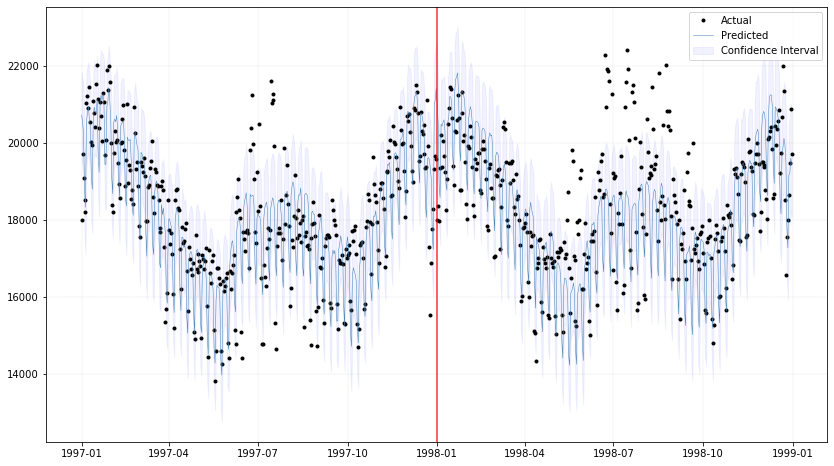

In [12]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

In [13]:
import seaborn as sns

def plot_joint_plot(full_pred_values, goback_years=1): 
    """
    
    """
    axes_titles = {'yhat': 'Predicted', 'y': 'Actual'}
    
    df = full_pred_values.copy(deep=True)
    final_year = df.index.year.unique()[-1]
    oos_start = df.loc[str(final_year)].index[0]
    
    if goback_years:
        start_year = final_year - goback_years +1
        df = df.loc[str(start_year): str(final_year)]
    
    g = sns.jointplot(x='yhat', y='y', data = df, kind="reg", color="0.4")
    
    g.fig.set_figwidth(10)
    g.fig.set_figheight(10)
    g.ax_joint.set_xlabel(axes_titles['yhat'])
    g.ax_joint.set_ylabel(axes_titles['y'])

    return g, g.ax_joint

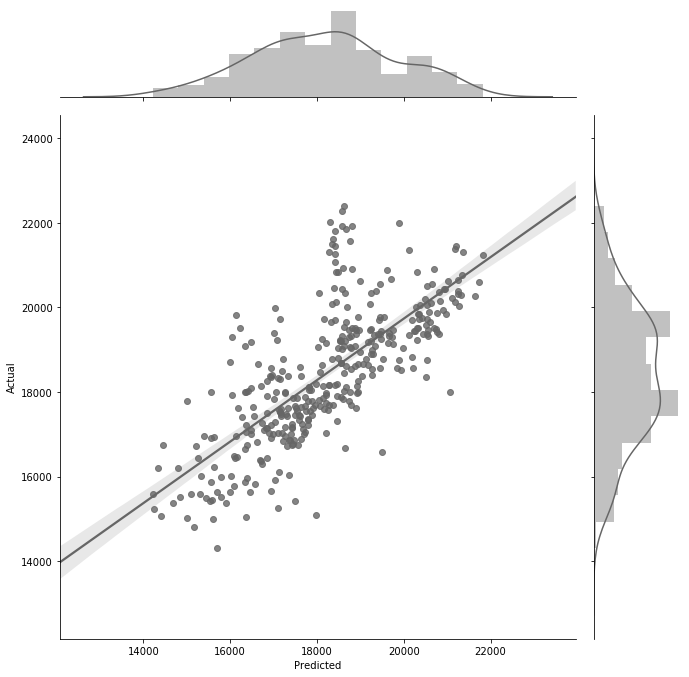

In [14]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();